# Analytical Finance Winter Break Intro Assignment
### Jordan Ehlinger (je28596)

## Read in and clean data

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [136]:
fundq = pd.read_csv('Fundamental Quarterly.csv')
# filter out un-needed columns
fundq = fundq[['LPERMNO', 'datadate', 'xrdq', 'exchg', 'fic', 'sic']]
# filter out securities listed on irrelevant exchanges
fundq = fundq[(fundq['exchg'] >= 11) & (fundq['exchg'] <= 19)]
# filter out securities not listed in the US
fundq = fundq[fundq['fic'].str.contains('USA')]
# filter out financial companies
fundq = fundq[~((fundq['sic'] >= 6000) & (fundq['sic'] <= 6999))]
# filter out pharma companies
fundq = fundq[~(fundq['sic'] == 2834)]
# turn datadate col into datetime
fundq['datadate'] = pd.to_datetime(fundq['datadate'])

In [137]:
### need to lag Fundamental Quarterly data by 3 months ie. 1 quarter
fundq['datadate'] = fundq['datadate'] + pd.DateOffset(months=3)
# remove rest of un-needed cols
fundq = fundq[['datadate', 'LPERMNO', 'xrdq']]
# convert NaN values to 0 for calculations below
fundq['xrdq'] = fundq['xrdq'].fillna(0)
# create new column for the year
fundq['year'] = fundq['datadate'].dt.year
# filter out unneeded years
fundq = fundq[~(fundq['year'] > 2021)]
fundq = fundq[~(fundq['year'] < 1989)]
fundq

,datadate,LPERMNO,xrdq,year
30,1989-01-31,10031,0.000,1989
31,1989-04-30,10031,0.000,1989
32,1989-07-30,10031,0.000,1989
33,1989-10-31,10031,0.000,1989
75,1989-02-28,54594,0.000,1989
...,...,...,...,...
1087483,2021-06-30,15533,41.128,2021
1087484,2021-09-30,15533,53.800,2021
1087485,2021-12-30,15533,49.277,2021
1087513,2021-11-30,17324,0.000,2021


In [138]:
sec_mon = pd.read_csv('Security Monthly.csv')
# filter out securities listed on irrelevant exchanges
sec_mon = sec_mon[(sec_mon['exchg'] >= 11) & (sec_mon['exchg'] <= 19)]
# filter out securities not listed in the US
sec_mon = sec_mon[sec_mon['fic'].str.contains('USA')]
# filter out financial companies
sec_mon = sec_mon[~((sec_mon['sic'] >= 6000) & (sec_mon['sic'] <= 6999))]
# filter out pharma companies
sec_mon = sec_mon[~(sec_mon['sic'] == 2834)]
# convert non-numeric values to NaN
sec_mon['trt1m'] = pd.to_numeric(sec_mon['trt1m'], errors='coerce')
# remove rows with NaN in 'trt1m' column
sec_mon = sec_mon.dropna(subset=['trt1m'])
# filter out returns below -100
sec_mon = sec_mon[~(sec_mon['trt1m'] < -100)]
# convert monthly returns to decimal
sec_mon['trt1m'] = sec_mon['trt1m']/100
# convert nan to 0
sec_mon['prccm'] = sec_mon['prccm'].fillna(0)
# turn datadate col into datetime
sec_mon['datadate'] = pd.to_datetime(sec_mon['datadate'])
# filter out un-needed cols
sec_mon = sec_mon[['datadate', 'LPERMNO', 'prccm', 'trt1m', 'cshoq']]
# sort by company code and date
sec_mon.sort_values(by=['LPERMNO', 'datadate'], inplace=True)
# group by company and quarter, then forward fill the quarterly shares outstanding within each group
sec_mon['cshoq'] = sec_mon.groupby(['LPERMNO'])['cshoq'].ffill()
# create new col for mkt cap
sec_mon['mkt_cap'] = sec_mon['prccm']*sec_mon['cshoq']
# create new col for month
sec_mon['month'] = sec_mon['datadate'].dt.month
# create new col for year
sec_mon['year'] = sec_mon['datadate'].dt.year
# convert to smaller dtype to save memory
sec_mon['LPERMNO'] = sec_mon['LPERMNO'].astype('int32')
sec_mon['trt1m'] = sec_mon['trt1m'].astype('float32')
# group by LPERMNO and shift market cap forward one month since it is recorded at the end of the month
sec_mon['mkt_cap'] = sec_mon.groupby(['LPERMNO'])['mkt_cap'].shift(1)
# convert NaN values to 0
sec_mon['mkt_cap'] = sec_mon['mkt_cap'].fillna(0)

sec_mon

,datadate,LPERMNO,prccm,trt1m,cshoq,mkt_cap,month,year
1434389,1986-02-28,10000,3.125,-0.264706,NaN,0.000000,2,1986
1434388,1986-03-31,10000,4.375,0.400000,NaN,0.000000,3,1986
1434387,1986-04-30,10000,3.875,-0.114286,3.793,0.000000,4,1986
1434386,1986-05-31,10000,3.062,-0.209807,3.793,14.697875,5,1986
1434385,1986-06-30,10000,3.062,0.000000,3.793,11.614166,6,1986
...,...,...,...,...,...,...,...,...
3399013,2023-08-31,93436,258.080,-0.034962,3174.000,848822.820000,8,2023
3399078,2023-09-30,93436,250.220,-0.030456,3179.000,819145.920000,9,2023
3399036,2023-10-31,93436,200.840,-0.197346,3179.000,795449.380000,10,2023
3399039,2023-11-30,93436,240.080,0.195379,3179.000,638470.360000,11,2023


In [139]:
CRSP_idx = pd.read_csv('CRSP_Stock_Market_Indexes.csv')
CRSP_idx['DATE'] = pd.to_datetime(CRSP_idx['DATE'])
# create new col for month
CRSP_idx['month'] = CRSP_idx['DATE'].dt.month
# create new col for year
CRSP_idx['year'] = CRSP_idx['DATE'].dt.year
CRSP_idx.drop('DATE', axis=1, inplace=True)
CRSP_idx

,vwretd,month,year
0,-0.070114,1,1990
1,0.014900,2,1990
2,0.024148,3,1990
3,-0.028283,4,1990
4,0.088935,5,1990
...,...,...,...
391,-0.036240,8,2022
392,-0.091324,9,2022
393,0.077403,10,2022
394,0.052365,11,2022


## Find companies with Positive or Zero annualized R&D expenditure for each year

In [140]:
# create series grouped by year that pulls in a single LPERMNO if it has an R&D expenditure above zero
RD_LP_yr = fundq.groupby(['year', 'LPERMNO'])['xrdq'].sum().reset_index()
RD_LP_yr = RD_LP_yr[RD_LP_yr['xrdq'] > 0].groupby('year')['LPERMNO'].unique()
# convert the series into a dictionary
RD_dict = RD_LP_yr.to_dict()
# shift the years forward by one so when we connect to returns it will be for the correct years since we are looking at R&D expenditure for the previous year
RD_dict = {year+1: value for year, value in RD_dict.items()}
RD_dict

{1990: array([10010, 10012, 10019, ..., 93201, 93236, 93252]),
 1991: array([10010, 10012, 10016, ..., 93201, 93236, 93252]),
 1992: array([10010, 10012, 10016, ..., 92903, 93236, 93252]),
 1993: array([10010, 10012, 10016, ..., 92903, 93236, 93252]),
 1994: array([10010, 10012, 10016, ..., 92866, 92903, 93236]),
 1995: array([10010, 10012, 10016, ..., 92903, 93236, 93316]),
 1996: array([10010, 10012, 10016, ..., 92903, 93236, 93316]),
 1997: array([10012, 10016, 10019, ..., 92903, 93236, 93316]),
 1998: array([10012, 10016, 10019, ..., 92903, 93236, 93316]),
 1999: array([10012, 10016, 10019, ..., 92866, 93236, 93316]),
 2000: array([10012, 10016, 10025, ..., 92583, 92866, 93316]),
 2001: array([10012, 10016, 10019, ..., 92225, 92399, 92583]),
 2002: array([10012, 10016, 10019, ..., 92225, 92399, 92583]),
 2003: array([10012, 10025, 10078, ..., 92399, 92583, 92874]),
 2004: array([10012, 10025, 10078, ..., 92399, 92583, 92874]),
 2005: array([10012, 10025, 10078, ..., 92399, 92583, 9

In [141]:
# filter the returns dataframe using the R&D dict so we get just the returns for the correct years/securities
RD_sec_mon = pd.concat([sec_mon[(sec_mon['datadate'].dt.year == year) & (sec_mon['LPERMNO'].isin(lpermno))]for year, lpermno in RD_dict.items()], ignore_index=True)
RD_sec_mon

,datadate,LPERMNO,prccm,trt1m,cshoq,mkt_cap,month,year
0,1990-01-31,10010,2.250,-0.162635,6.673,17.957221,1,1990
1,1990-02-28,10010,2.875,0.277778,6.673,15.014250,2,1990
2,1990-03-31,10010,2.875,0.000000,6.673,19.184875,3,1990
3,1990-04-30,10010,2.750,-0.043478,6.655,19.184875,4,1990
4,1990-05-31,10010,5.125,0.863637,6.655,18.301250,5,1990
...,...,...,...,...,...,...,...,...
672870,2022-08-31,93436,275.610,-0.072489,1041.000,927999.450000,8,2022
672871,2022-09-30,93436,265.250,-0.037589,3158.000,286910.010000,9,2022
672872,2022-10-31,93436,227.540,-0.142168,3158.000,837659.500000,10,2022
672873,2022-11-30,93436,194.700,-0.144326,3158.000,718571.320000,11,2022


In [142]:
# create series grouped by year that pulls in a single LPERMNO if it has an R&D expenditure less than or equal to zero
Zero_LP_yr = fundq.groupby(['year', 'LPERMNO'])['xrdq'].sum().reset_index()
Zero_LP_yr = Zero_LP_yr[Zero_LP_yr['xrdq'] <= 0].groupby('year')['LPERMNO'].unique()
# convert the series into a dictionary
Zero_dict = Zero_LP_yr.to_dict()
# shift the years forward by one so when we connect to returns it will be for the correct years since we are looking at R&D expenditure for the previous year
Zero_dict = {year+1: value for year, value in Zero_dict.items()}
Zero_dict

{1990: array([10001, 10005, 10007, ..., 93156, 93220, 93316]),
 1991: array([10001, 10005, 10007, ..., 93156, 93220, 93316]),
 1992: array([10001, 10005, 10011, ..., 93156, 93220, 93316]),
 1993: array([10001, 10011, 10018, ..., 93009, 93025, 93316]),
 1994: array([10001, 10011, 10018, ..., 93009, 93025, 93316]),
 1995: array([10001, 10011, 10018, ..., 92997, 93009, 93025]),
 1996: array([10001, 10011, 10018, ..., 92874, 93009, 93025]),
 1997: array([10001, 10011, 10018, ..., 92874, 93009, 93025]),
 1998: array([10001, 10011, 10026, ..., 92874, 93009, 93025]),
 1999: array([10001, 10011, 10026, ..., 92874, 93009, 93025]),
 2000: array([10001, 10019, 10026, ..., 92874, 93009, 93025]),
 2001: array([10001, 10026, 10028, ..., 92340, 92874, 93316]),
 2002: array([10001, 10026, 10028, ..., 92073, 92340, 92874]),
 2003: array([10001, 10019, 10026, ..., 91804, 92073, 92340]),
 2004: array([10001, 10026, 10028, ..., 91804, 92073, 92340]),
 2005: array([10001, 10026, 10028, ..., 91687, 92073, 9

In [143]:
# filter the returns dataframe using the Zero dict so we get just the returns for the correct years/securities
Zero_sec_mon = pd.concat([sec_mon[(sec_mon['datadate'].dt.year == year) & (sec_mon['LPERMNO'].isin(lpermno))]for year, lpermno in Zero_dict.items()], ignore_index=True)
Zero_sec_mon

,datadate,LPERMNO,prccm,trt1m,cshoq,mkt_cap,month,year
0,1990-01-31,10001,9.875,-0.024691,1.022,10.347750,1,1990
1,1990-02-28,10001,10.000,0.012658,1.022,10.092250,2,1990
2,1990-03-31,10001,10.125,0.025000,1.027,10.220000,3,1990
3,1990-04-30,10001,10.000,-0.012346,1.027,10.398375,4,1990
4,1990-05-31,10001,9.750,-0.025000,1.027,10.270000,5,1990
...,...,...,...,...,...,...,...,...
763871,2022-08-31,93423,22.150,-0.022938,83.027,1882.222090,8,2022
763872,2022-09-30,93423,17.700,-0.200903,83.153,1839.048050,9,2022
763873,2022-10-31,93423,22.300,0.259887,83.153,1471.808100,10,2022
763874,2022-11-30,93423,24.090,0.080269,83.153,1854.311900,11,2022


In [146]:
# make sure all companies are captured in either dict
non_match = {}
for year in range(1979, 2022):
    mask = (fundq['datadate'].dt.year==year)
    # find total number of securities for this year
    len1 = len(fundq[mask].groupby('LPERMNO'))
    # since R&D dict is missing the first few years
    if year in RD_dict.keys():
        # find the total number of securities stored in either of our dicts (portfolios)
        len2 = len(RD_dict[year+1]) + len(Zero_dict[year+1])
    else:
        continue
    # these two values should equal zero
    diff = len1 - len2
    # if there is any difference then it shows that not all of the securities for thar year were captured by either dict
    if diff > 0:
        non_match[year] = diff
# dict shows which years hold a difference and how many securities fell through the cracks
non_match

{}

## For the R&D and Zero portfolios, create value and equally weighted portfolios

### Equal-weighted Portfolios

In [147]:
# create a copy of the R&D dataframe so we can formulate a df for the equal-weighted portfolio
RD_EW_Port = RD_sec_mon[['datadate', 'LPERMNO', 'trt1m', 'year', 'month']].copy()
# group by year and month and calculate the total number of securities for each month
tot_mon_sec = RD_EW_Port.groupby(['year', 'month'])['LPERMNO'].transform('count')
# calculate the weight for each security as the reciprocal of the count for that month
RD_EW_Port['weight'] = 1 / tot_mon_sec
# create new column for the weighted return
RD_EW_Port['weighted_return'] = RD_EW_Port['trt1m'] * RD_EW_Port['weight']
RD_EW_Port

,datadate,LPERMNO,trt1m,year,month,weight,weighted_return
0,1990-01-31,10010,-0.162635,1990,1,0.000871,-0.000142
1,1990-02-28,10010,0.277778,1990,2,0.000876,0.000243
2,1990-03-31,10010,0.000000,1990,3,0.000881,0.000000
3,1990-04-30,10010,-0.043478,1990,4,0.000885,-0.000038
4,1990-05-31,10010,0.863637,1990,5,0.000895,0.000773
...,...,...,...,...,...,...,...
672870,2022-08-31,93436,-0.072489,2022,8,0.000556,-0.000040
672871,2022-09-30,93436,-0.037589,2022,9,0.000559,-0.000021
672872,2022-10-31,93436,-0.142168,2022,10,0.000561,-0.000080
672873,2022-11-30,93436,-0.144326,2022,11,0.000565,-0.000081


In [148]:
# test if equal weighting is working, should only have one value in the array
yrmask = RD_EW_Port['datadate'].dt.year == (1995)
momask = RD_EW_Port['datadate'].dt.month == (1)
RD_EW_Port[yrmask & momask]['weight'].unique()

array([0.00049213])

In [149]:
# create a copy of the R&D dataframe so we can formulate a df for the equal-weighted portfolio
Zero_EW_Port = Zero_sec_mon[['datadate', 'LPERMNO', 'trt1m', 'year', 'month']].copy()
# group by year and month and calculate the total number of securities for each month
tot_mon_sec = Zero_EW_Port.groupby(['year', 'month'])['LPERMNO'].transform('count')
# calculate the weight for each security as the reciprocal of the count for that month
Zero_EW_Port['weight'] = 1 / tot_mon_sec
# create new column for the weighted return
Zero_EW_Port['weighted_return'] = Zero_EW_Port['trt1m'] * Zero_EW_Port['weight']
Zero_EW_Port

,datadate,LPERMNO,trt1m,year,month,weight,weighted_return
0,1990-01-31,10001,-0.024691,1990,1,0.000336,-0.000008
1,1990-02-28,10001,0.012658,1990,2,0.000338,0.000004
2,1990-03-31,10001,0.025000,1990,3,0.000342,0.000009
3,1990-04-30,10001,-0.012346,1990,4,0.000344,-0.000004
4,1990-05-31,10001,-0.025000,1990,5,0.000346,-0.000009
...,...,...,...,...,...,...,...
763871,2022-08-31,93423,-0.022938,2022,8,0.000776,-0.000018
763872,2022-09-30,93423,-0.200903,2022,9,0.000780,-0.000157
763873,2022-10-31,93423,0.259887,2022,10,0.000784,0.000204
763874,2022-11-30,93423,0.080269,2022,11,0.000789,0.000063


In [150]:
# test if equal weighting is working, should only have one value in the array
yrmask = Zero_EW_Port['datadate'].dt.year == (1995)
momask = Zero_EW_Port['datadate'].dt.month == (1)
Zero_EW_Port[yrmask & momask]['weight'].unique()

array([0.0003465])

### Value-weighted Portfolios

In [151]:
# create a copy of the R&D dataframe so we can formulate a df for the value-weighted portfolio
RD_VW_Port = RD_sec_mon[['datadate', 'LPERMNO', 'trt1m', 'mkt_cap', 'year', 'month']].copy()
# group by year and month to calculate the total market cap for each month
total_mktcap_by_month = RD_VW_Port.groupby(['year', 'month'])['mkt_cap'].transform('sum')
# calculate the weight for each security as its market cap divided by the total market cap for that month
RD_VW_Port['weight'] = RD_VW_Port['mkt_cap'] / total_mktcap_by_month
# create new column for the weighted return
RD_VW_Port['weighted_return'] = RD_VW_Port['trt1m'] * RD_VW_Port['weight']
RD_VW_Port

,datadate,LPERMNO,trt1m,mkt_cap,year,month,weight,weighted_return
0,1990-01-31,10010,-0.162635,17.957221,1990,1,0.000036,-0.000006
1,1990-02-28,10010,0.277778,15.014250,1990,2,0.000032,0.000009
2,1990-03-31,10010,0.000000,19.184875,1990,3,0.000039,0.000000
3,1990-04-30,10010,-0.043478,19.184875,1990,4,0.000037,-0.000002
4,1990-05-31,10010,0.863637,18.301250,1990,5,0.000037,0.000032
...,...,...,...,...,...,...,...,...
672870,2022-08-31,93436,-0.072489,927999.450000,2022,8,0.042081,-0.003050
672871,2022-09-30,93436,-0.037589,286910.010000,2022,9,0.013997,-0.000526
672872,2022-10-31,93436,-0.142168,837659.500000,2022,10,0.041889,-0.005955
672873,2022-11-30,93436,-0.144326,718571.320000,2022,11,0.033924,-0.004896


In [152]:
# create a copy of the Zero dataframe so we can formulate a df for the value-weighted portfolio
Zero_VW_Port = Zero_sec_mon[['datadate', 'LPERMNO', 'trt1m', 'mkt_cap', 'year', 'month']].copy()
# group by year and month to calculate the total market cap for each month
total_mktcap_by_month = Zero_VW_Port.groupby(['year', 'month'])['mkt_cap'].transform('sum')
# calculate the weight for each security as its market cap divided by the total market cap for that month
Zero_VW_Port['weight'] = Zero_VW_Port['mkt_cap'] / total_mktcap_by_month
# create new column for the weighted return
Zero_VW_Port['weighted_return'] = Zero_VW_Port['trt1m'] * Zero_VW_Port['weight']
Zero_VW_Port

,datadate,LPERMNO,trt1m,mkt_cap,year,month,weight,weighted_return
0,1990-01-31,10001,-0.024691,10.347750,1990,1,0.000006,-1.457608e-07
1,1990-02-28,10001,0.012658,10.092250,1990,2,0.000006,8.048621e-08
2,1990-03-31,10001,0.025000,10.220000,1990,3,0.000006,1.603499e-07
3,1990-04-30,10001,-0.012346,10.398375,1990,4,0.000006,-7.795302e-08
4,1990-05-31,10001,-0.025000,10.270000,1990,5,0.000006,-1.612727e-07
...,...,...,...,...,...,...,...,...
763871,2022-08-31,93423,-0.022938,1882.222090,2022,8,0.000172,-3.955802e-06
763872,2022-09-30,93423,-0.200903,1839.048050,2022,9,0.000172,-3.462641e-05
763873,2022-10-31,93423,0.259887,1471.808100,2022,10,0.000153,3.982623e-05
763874,2022-11-30,93423,0.080269,1854.311900,2022,11,0.000177,1.423799e-05


### Risk-free rate returns

In [153]:
# read in monthly returns for 90 day tbills to use as risk free rate
rf_rate = pd.read_csv('F-F_Research_Data_Factors.csv', dtype={'Year-Month':str})
rf_rate['year'] = rf_rate['Year-Month'].str[:4].astype(int)
rf_rate['month'] = rf_rate['Year-Month'].str[-2:].astype(int)
rf_rate = rf_rate[['year', 'month', 'RF']]
# convert RF rate into a decimal
rf_rate['RF'] = rf_rate['RF']/100
rf_rate

,year,month,RF
0,1926,7,0.0022
1,1926,8,0.0025
2,1926,9,0.0023
3,1926,10,0.0032
4,1926,11,0.0031
...,...,...,...
1164,2023,7,0.0045
1165,2023,8,0.0045
1166,2023,9,0.0043
1167,2023,10,0.0047


### Sum monthly returns for each portfolio and merge them into one dataframe

In [154]:
# group by year and month and sum the weighted returns for each portfolio and the index
tot_wgt_rtns_RD_EW = RD_EW_Port.groupby(['year', 'month'])['weighted_return'].sum().reset_index()
tot_wgt_rtns_Zero_EW = Zero_EW_Port.groupby(['year', 'month'])['weighted_return'].sum().reset_index()
tot_wgt_rtns_RD_VW = RD_VW_Port.groupby(['year', 'month'])['weighted_return'].sum().reset_index()
tot_wgt_rtns_Zero_VW = Zero_VW_Port.groupby(['year', 'month'])['weighted_return'].sum().reset_index()

In [155]:
# merge each of the dataframes created above into a single dataframe
linreg_df = pd.merge(rf_rate, tot_wgt_rtns_RD_EW, on=['year', 'month'])
linreg_df = pd.merge(linreg_df, tot_wgt_rtns_Zero_EW, on=['year', 'month'], suffixes=('', '_Zero_EW'))
linreg_df = pd.merge(linreg_df, tot_wgt_rtns_RD_VW, on=['year', 'month'], suffixes=('', '_RD_VW'))
linreg_df = pd.merge(linreg_df, tot_wgt_rtns_Zero_VW, on=['year', 'month'], suffixes=('', '_Zero_VW'))
linreg_df = pd.merge(linreg_df, CRSP_idx, on=['year', 'month'])
# suffix parameter doesn't work for first merge since the column values are already different, so changing the name for clarity here
linreg_df = linreg_df.rename(columns={'weighted_return': 'weighted_return_RD_EW'})
# filter out unneeded years
linreg_df = linreg_df[~(linreg_df['year'] > 2022)]
linreg_df = linreg_df[~(linreg_df['year'] < 1990)]
linreg_df

,year,month,RF,weighted_return_RD_EW,weighted_return_Zero_EW,weighted_return_RD_VW,weighted_return_Zero_VW,vwretd
0,1990,1,0.0057,-0.054611,-0.050002,-0.052398,-0.073202,-0.070114
1,1990,2,0.0057,0.039417,0.025573,0.028780,0.011992,0.014900
2,1990,3,0.0064,0.050802,0.031616,0.048318,0.024937,0.024148
3,1990,4,0.0069,-0.008815,-0.024788,-0.015325,-0.028225,-0.028283
4,1990,5,0.0068,0.090500,0.052872,0.107462,0.081609,0.088935
...,...,...,...,...,...,...,...,...
391,2022,8,0.0019,0.001026,0.001029,-0.042495,-0.019279,-0.036240
392,2022,9,0.0019,-0.120857,-0.121378,-0.102969,-0.094476,-0.091324
393,2022,10,0.0023,0.053541,0.100530,0.061259,0.092781,0.077403
394,2022,11,0.0029,-0.008429,0.019755,0.043737,0.063486,0.052365


#### Graphing Returns

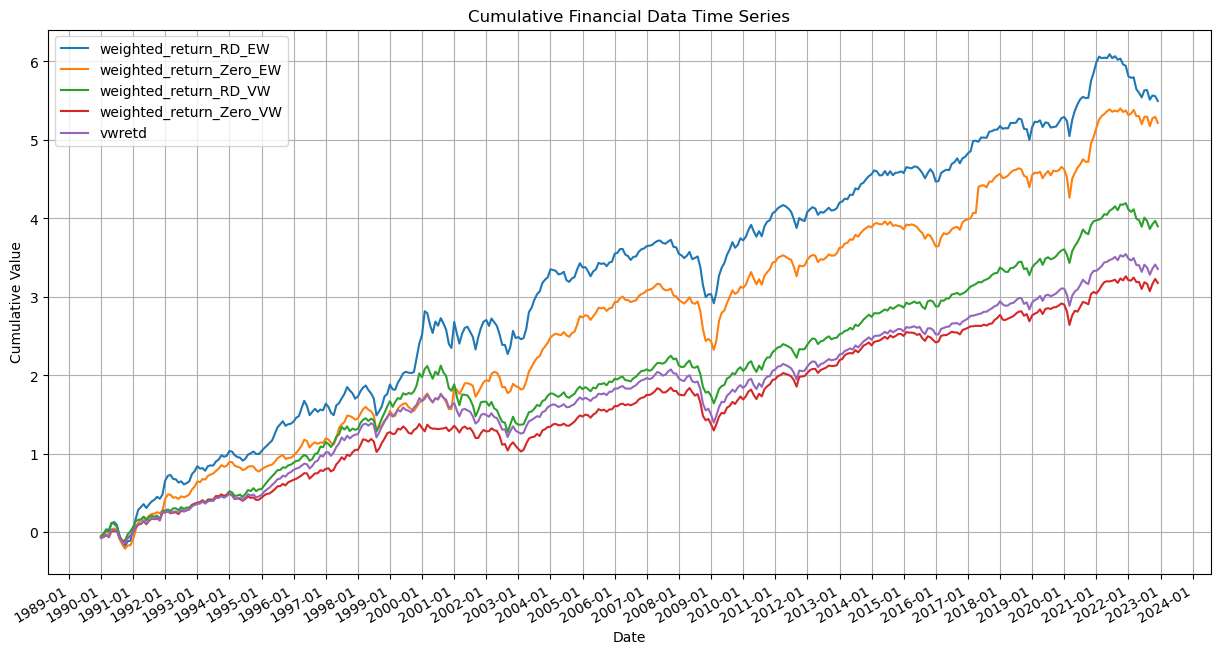

In [156]:
### code for this graph was acquired from ChatGPT
# create copy of df so we can make changes
base_rtns_df = linreg_df.copy()

# Convert the 'year' and 'month' into a datetime object for plotting
base_rtns_df['date'] = pd.to_datetime(base_rtns_df.assign(day=1)[['year', 'month', 'day']])
base_rtns_df.set_index('date', inplace=True)
base_rtns_df.drop(['year', 'month', 'RF'], axis=1, inplace=True)

# Calculate the cumulative sum of each column to reflect time series data
cumulative_df = base_rtns_df.cumsum()

# Plot each column as a separate line
plt.figure(figsize=(15, 8))
for column in cumulative_df.columns:
    plt.plot(cumulative_df.index, cumulative_df[column], label=column)

# Define the date format for the x-axis and rotate the dates for better visibility
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()

# Adding title and labels
plt.title('Cumulative Financial Data Time Series')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

## Calculate each portfolio's alpha with respect to the CRSP value-weighted index (vwretd)

In [157]:
# subtract out the risk free rate from each column of returns to calculate their premiums before running them through the linear regression model
linreg_df['RD_EW_Prem'] = linreg_df['weighted_return_RD_EW'] - linreg_df['RF']
linreg_df['Zero_EW_Prem'] = linreg_df['weighted_return_Zero_EW'] - linreg_df['RF']
linreg_df['RD_VW_Prem'] = linreg_df['weighted_return_RD_VW'] - linreg_df['RF']
linreg_df['Zero_VW_Prem'] = linreg_df['weighted_return_Zero_VW'] - linreg_df['RF']
linreg_df['Index_Prem'] = linreg_df['vwretd'] - linreg_df['RF']
linreg_df['Long_Short_EW'] = linreg_df['weighted_return_RD_EW'] - linreg_df['weighted_return_Zero_EW']
linreg_df['Long_Short_VW'] = linreg_df['weighted_return_RD_VW'] - linreg_df['weighted_return_Zero_VW']
linreg_df = linreg_df[['year', 'month', 'RF', 'RD_EW_Prem', 'Zero_EW_Prem', 'RD_VW_Prem', 'Zero_VW_Prem', 'Index_Prem', 'Long_Short_EW', 'Long_Short_VW']]
linreg_df

,year,month,RF,RD_EW_Prem,Zero_EW_Prem,RD_VW_Prem,Zero_VW_Prem,Index_Prem,Long_Short_EW,Long_Short_VW
0,1990,1,0.0057,-0.060311,-0.055702,-0.058098,-0.078902,-0.075814,-0.004609,0.020804
1,1990,2,0.0057,0.033717,0.019873,0.023080,0.006292,0.009200,0.013845,0.016789
2,1990,3,0.0064,0.044402,0.025216,0.041918,0.018537,0.017748,0.019186,0.023381
3,1990,4,0.0069,-0.015715,-0.031688,-0.022225,-0.035125,-0.035183,0.015973,0.012900
4,1990,5,0.0068,0.083700,0.046072,0.100662,0.074809,0.082135,0.037628,0.025854
...,...,...,...,...,...,...,...,...,...,...
391,2022,8,0.0019,-0.000874,-0.000871,-0.044395,-0.021179,-0.038140,-0.000003,-0.023216
392,2022,9,0.0019,-0.122757,-0.123278,-0.104869,-0.096376,-0.093224,0.000521,-0.008493
393,2022,10,0.0023,0.051241,0.098230,0.058959,0.090481,0.075103,-0.046989,-0.031522
394,2022,11,0.0029,-0.011329,0.016855,0.040837,0.060586,0.049465,-0.028184,-0.019749


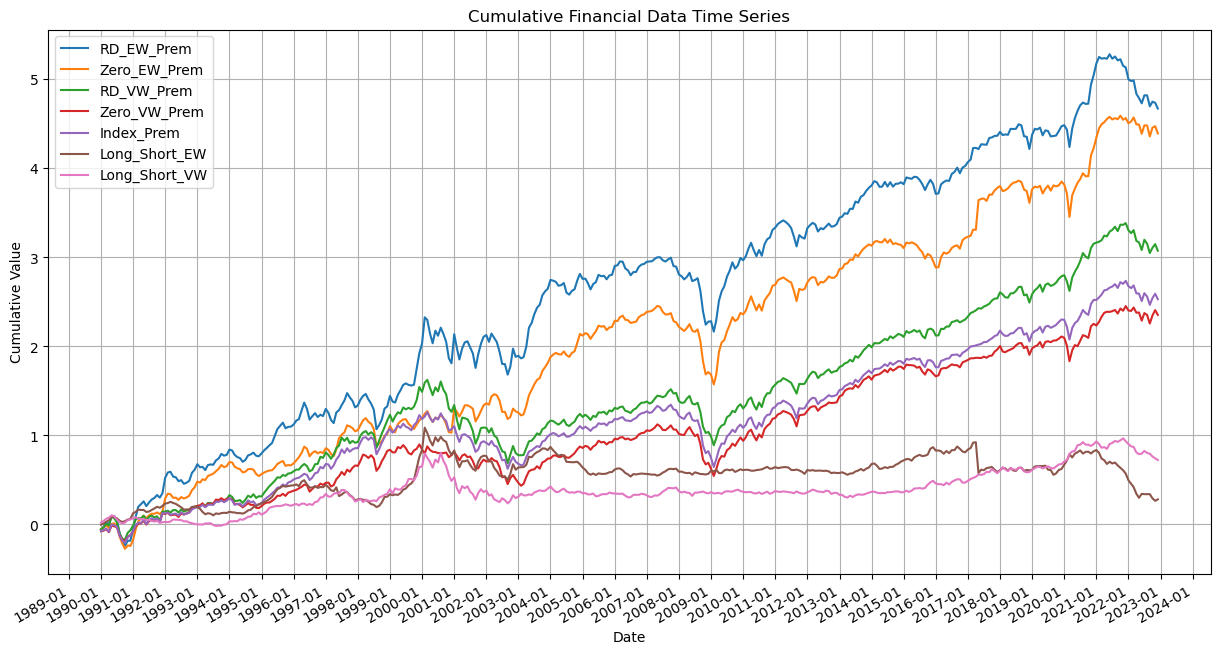

In [158]:
### code for this graph was acquired from ChatGPT
# create copy of df so we can make changes
prems_df = linreg_df.copy()

# Convert the 'year' and 'month' into a datetime object for plotting
prems_df['date'] = pd.to_datetime(prems_df.assign(day=1)[['year', 'month', 'day']])
prems_df.set_index('date', inplace=True)
prems_df.drop(['year', 'month', 'RF'], axis=1, inplace=True)

# Calculate the cumulative sum of each column to reflect time series data
cumulative_df = prems_df.cumsum()

# Plot each column as a separate line
plt.figure(figsize=(15, 8))
for column in cumulative_df.columns:
    plt.plot(cumulative_df.index, cumulative_df[column], label=column)

# Define the date format for the x-axis and rotate the dates for better visibility
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()

# Adding title and labels
plt.title('Cumulative Financial Data Time Series')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

### Positive R&D Expenditure Portfolios

#### Equal-Weighted R&D Portfolio Regression Results

In [165]:
import statsmodels.api as sm

# declare independent and dependent variable from dataframe
X = linreg_df['Index_Prem']
y = linreg_df['RD_EW_Prem']
# add a constant to the our independent variable to allow for non-zero intercept
X2 = sm.add_constant(X)

# create the OLS regression model and fit it
lin_reg = sm.OLS(y, X2).fit()
# print a summary
print(lin_reg.summary())

                            OLS Regression Results                            
Dep. Variable:             RD_EW_Prem   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     753.7
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           1.67e-93
Time:                        13:22:26   Log-Likelihood:                 685.21
No. Observations:                 396   AIC:                            -1366.
Df Residuals:                     394   BIC:                            -1358.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.486      0.1

#### Value-Weighted R&D Portfolio Regression Results

In [160]:
# declare independent and dependent variable from dataframe
X = linreg_df['Index_Prem']
y = linreg_df['RD_VW_Prem']
# add a constant to the our independent variable to allow for non-zero intercept
X2 = sm.add_constant(X)

# create the OLS regression model and fit it
lin_reg = sm.OLS(y, X2).fit()
# print a summary
print(lin_reg.summary())

                            OLS Regression Results                            
Dep. Variable:             RD_VW_Prem   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     4219.
Date:                Mon, 29 Jan 2024   Prob (F-statistic):          1.35e-212
Time:                        13:11:34   Log-Likelihood:                 1103.8
No. Observations:                 396   AIC:                            -2204.
Df Residuals:                     394   BIC:                            -2196.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.965      0.3

### Zero R&D Expenditure Portfolios

#### Equal-Weighted Zero R&D Expenditure Portfolio Regression Results

In [161]:
# declare independent and dependent variable from dataframe
X = linreg_df['Index_Prem']
y = linreg_df['Zero_EW_Prem']
# add a constant to the our independent variable to allow for non-zero intercept
X2 = sm.add_constant(X)

# create the OLS regression model and fit it
lin_reg = sm.OLS(y, X2).fit()
# print a summary
print(lin_reg.summary())

                            OLS Regression Results                            
Dep. Variable:           Zero_EW_Prem   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     720.9
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           5.07e-91
Time:                        13:11:35   Log-Likelihood:                 747.07
No. Observations:                 396   AIC:                            -1490.
Df Residuals:                     394   BIC:                            -1482.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.002      2.109      0.0

#### Value-Weighted Zero R&D Expenditure Portfolio Regression Results

In [162]:
# declare independent and dependent variable from dataframe
X = linreg_df['Index_Prem']
y = linreg_df['Zero_VW_Prem']
# add a constant to the our independent variable to allow for non-zero intercept
X2 = sm.add_constant(X)

# create the OLS regression model and fit it
lin_reg = sm.OLS(y, X2).fit()
# print a summary
print(lin_reg.summary())

                            OLS Regression Results                            
Dep. Variable:           Zero_VW_Prem   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     3563.
Date:                Mon, 29 Jan 2024   Prob (F-statistic):          1.78e-199
Time:                        13:11:35   Log-Likelihood:                 1156.7
No. Observations:                 396   AIC:                            -2309.
Df Residuals:                     394   BIC:                            -2301.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.431      0.6

### Long-Short Portfolios

#### Equal-Weighted Long-Short Portfolio Regression Results

In [163]:
# declare independent and dependent variable from dataframe
X = linreg_df['Index_Prem']
y = linreg_df['Long_Short_EW']
# add a constant to the our independent variable to allow for non-zero intercept
X2 = sm.add_constant(X)

# create the OLS regression model and fit it
lin_reg = sm.OLS(y, X2).fit()
# print a summary
print(lin_reg.summary())

                            OLS Regression Results                            
Dep. Variable:          Long_Short_EW   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     28.59
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           1.52e-07
Time:                        13:11:36   Log-Likelihood:                 754.64
No. Observations:                 396   AIC:                            -1505.
Df Residuals:                     394   BIC:                            -1497.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.002     -0.378      0.7

#### Value-Weighted Long-Short Portfolio Regression Results

In [164]:
# declare independent and dependent variable from dataframe
X = linreg_df['Index_Prem']
y = linreg_df['Long_Short_VW']
# add a constant to the our independent variable to allow for non-zero intercept
X2 = sm.add_constant(X)

# create the OLS regression model and fit it
lin_reg = sm.OLS(y, X2).fit()
# print a summary
print(lin_reg.summary())

                            OLS Regression Results                            
Dep. Variable:          Long_Short_VW   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     56.78
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           3.37e-13
Time:                        13:11:37   Log-Likelihood:                 896.44
No. Observations:                 396   AIC:                            -1789.
Df Residuals:                     394   BIC:                            -1781.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.348      0.7

### Export final dataframe to CSV

In [166]:
linreg_df = linreg_df[['year', 'month', 'RF', 'RD_EW_Prem', 'Zero_EW_Prem', 'RD_VW_Prem', 'Zero_VW_Prem', 'Index_Prem', 'Long_Short_EW', 'Long_Short_VW']]
linreg_df

,year,month,RF,RD_EW_Prem,Zero_EW_Prem,RD_VW_Prem,Zero_VW_Prem,Index_Prem,Long_Short_EW,Long_Short_VW
0,1990,1,0.0057,-0.060311,-0.055702,-0.058098,-0.078902,-0.075814,-0.004609,0.020804
1,1990,2,0.0057,0.033717,0.019873,0.023080,0.006292,0.009200,0.013845,0.016789
2,1990,3,0.0064,0.044402,0.025216,0.041918,0.018537,0.017748,0.019186,0.023381
3,1990,4,0.0069,-0.015715,-0.031688,-0.022225,-0.035125,-0.035183,0.015973,0.012900
4,1990,5,0.0068,0.083700,0.046072,0.100662,0.074809,0.082135,0.037628,0.025854
...,...,...,...,...,...,...,...,...,...,...
391,2022,8,0.0019,-0.000874,-0.000871,-0.044395,-0.021179,-0.038140,-0.000003,-0.023216
392,2022,9,0.0019,-0.122757,-0.123278,-0.104869,-0.096376,-0.093224,0.000521,-0.008493
393,2022,10,0.0023,0.051241,0.098230,0.058959,0.090481,0.075103,-0.046989,-0.031522
394,2022,11,0.0029,-0.011329,0.016855,0.040837,0.060586,0.049465,-0.028184,-0.019749


In [167]:
linreg_df.to_csv('Assignment0_final_dataframe.csv', index=False)